In [ ]:
import kagglehub
snap_amazon_fine_food_reviews_path = kagglehub.dataset_download('snap/amazon-fine-food-reviews')
kazanova_sentiment140_path = kagglehub.dataset_download('kazanova/sentiment140')
lakshmi25npathi_imdb_dataset_of_50k_movie_reviews_path = kagglehub.dataset_download('lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')
abhi8923shriv_sentiment_analysis_dataset_path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')
jp797498e_twitter_entity_sentiment_analysis_path = kagglehub.dataset_download('jp797498e/twitter-entity-sentiment-analysis')

print('Data source import complete.')


Data source import complete.


In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Regular expressions and string processing
import re
import string

# Model persistence
import pickle
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ==== NLP Libraries ====
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ==== Machine Learning Libraries ====
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Download essential NLTK resources (run once, comment out after first run)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# Set up plot aesthetics for better visuals
plt.style.use('ggplot')
sns.set(style='whitegrid')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Load datasets
train_data = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv', encoding='latin1')
test_data = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv', encoding='latin1')

# Display basic information
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Preview the first few rows of the training data
print("\nFirst 5 rows of training data:")
display(train_data.head())

Training data shape: (27481, 10)
Test data shape: (4815, 9)

First 5 rows of training data:


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [ ]:
# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum())

print("\nMissing values in test data:")
print(test_data.isnull().sum())


Missing values in training data:
textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

Missing values in test data:
textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64


In [ ]:
# Sentiment distribution in training data
print("\nSentiment distribution in training data:")
print(train_data['sentiment'].value_counts())


Sentiment distribution in training data:
sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64


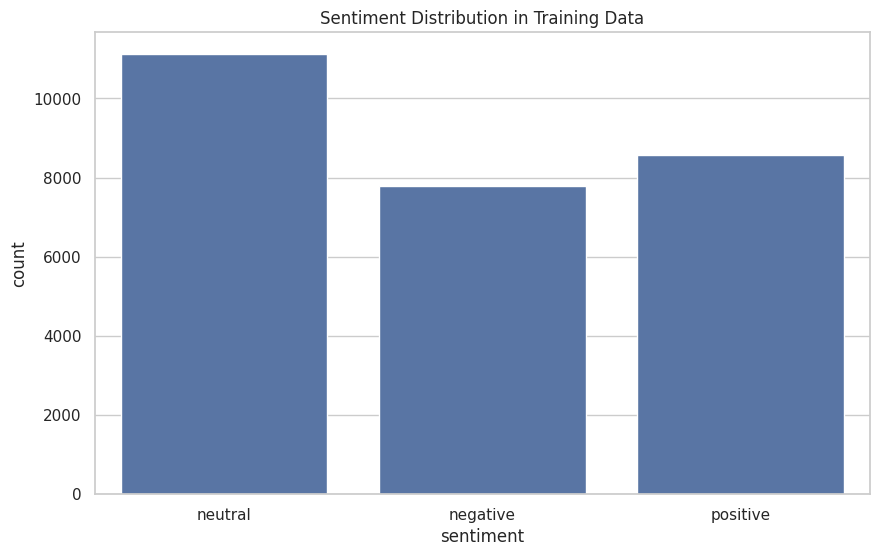

In [ ]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=train_data)
plt.title('Sentiment Distribution in Training Data')
plt.show()

# --- Teaching Note ---
# It's important to check for missing values and understand the sentiment distribution.
# Now, let's check for any issues before analyzing text length.

In [ ]:
# Convert 'text' to string to avoid errors with NaN (float) values
train_data['text'] = train_data['text'].astype(str)
test_data['text'] = test_data['text'].astype(str)

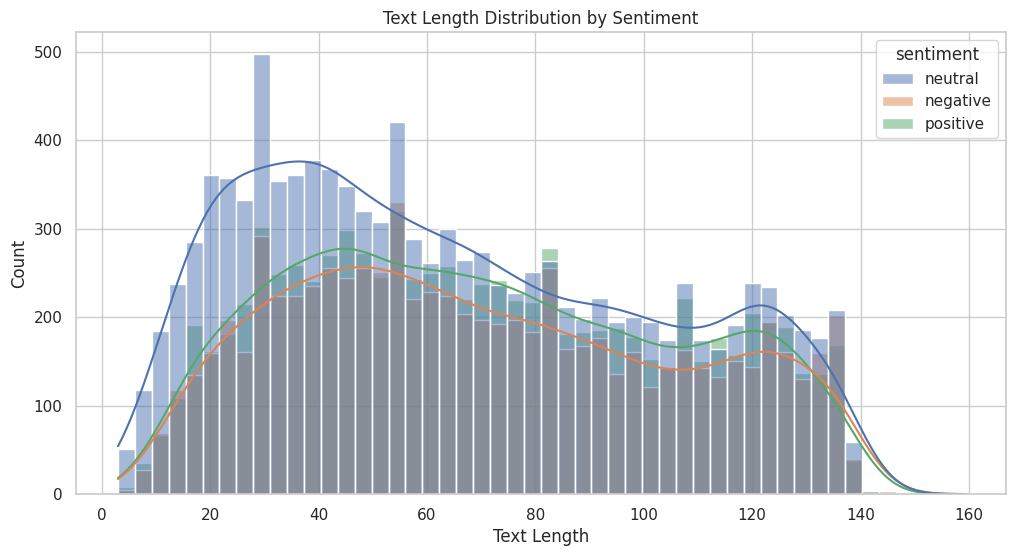

In [ ]:
# Explore text length distribution
train_data['text_length'] = train_data['text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data, x='text_length', hue='sentiment', bins=50, kde=True)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.show()

In [ ]:
def clean_text(text):
    """
    Clean and preprocess text data.

    Args:
        text (str): Input text

    Returns:
        str: Cleaned text
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (keeping the text after #)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text):
    """
    Full preprocessing pipeline: clean, tokenize, remove stopwords, and lemmatize.

    Args:
        text (str): Input text

    Returns:
        str: Preprocessed text
    """
    if pd.isna(text):
        return ""

    # Clean text
    text = clean_text(text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

# Assuming train_data and test_data are defined DataFrames
print("Preprocessing training data (this may take a few minutes)...")
train_data['processed_text'] = train_data['text'].apply(preprocess_text)

print("Preprocessing test data (this may take a few minutes)...")
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

# Display examples of original vs processed text
print("\nOriginal vs Processed Text Examples:")
for i in range(3):
    print(f"Original: {train_data.iloc[i]['text']}")
    print(f"Processed: {train_data.iloc[i]['processed_text']}")
    print("---")

Preprocessing training data (this may take a few minutes)...


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
sentiment_mapping = {'negative': 0, 'neutral': 2, 'positive': 4}

# Check if sentiment column contains text labels or numerical values
if train_data['sentiment'].dtype == 'object':
    train_data['sentiment_encoded'] = train_data['sentiment'].map(sentiment_mapping)
    test_data['sentiment_encoded'] = test_data['sentiment'].map(sentiment_mapping)
else:
    # If they're already numerical, just copy them
    train_data['sentiment_encoded'] = train_data['sentiment']
    test_data['sentiment_encoded'] = test_data['sentiment']

In [ ]:
test_data = test_data.dropna(subset=['text', 'sentiment'])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data['processed_text'],
    train_data['sentiment_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=train_data['sentiment_encoded']
)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])

KeyError: 'processed_text'